In [1]:
using DataFrames, Dates, Plots, CSV, DataFramesMeta, MLJ, StatsPlots, LaTeXStrings, DifferentialEquations
using Turing
using LazyArrays
using Random: seed!

In [2]:
function data_processing(country::String)
    data = CSV.read("../data/confirmed_cases_global.csv", DataFrame)
    rename!(data, 1 => "province", 2 => "country")
    countries = collect(data[:, 2])
    row = findfirst(countries .== country)
    data_row = data[row, :]
    country_data = [i for i in values(data_row[5:end])]
    
    date_strings =String.(names(data))[5:end]
    format = Dates.DateFormat("m/d/Y")
    dates = parse.(Date, date_strings, format) + Year(2000)

    df = DataFrame(confirmed = country_data, dates = dates)    
    return df
end

data_processing (generic function with 1 method)

In [3]:
start_date = Date(2020,03,01);
end_date = Date(2020,12,01);

In [4]:
ng_data = data_processing("Nigeria");

# ng_filtered = @subset(ng_data, :confirmed .> 0)

Row,confirmed,dates
,Int64,Date
1,0,2020-01-22
2,0,2020-01-23
3,0,2020-01-24
4,0,2020-01-25
5,0,2020-01-26
6,0,2020-01-27
7,0,2020-01-28
8,0,2020-01-29
9,0,2020-01-30


In [5]:
# range_data = ng_filtered[2,start_date:end_date]

ng = filter(row -> start_date <= row.dates <= end_date, ng_data)

Row,confirmed,dates
,Int64,Date
1,1,2020-03-01
2,1,2020-03-02
3,1,2020-03-03
4,1,2020-03-04
5,1,2020-03-05
6,1,2020-03-06
7,1,2020-03-07
8,1,2020-03-08
9,2,2020-03-09


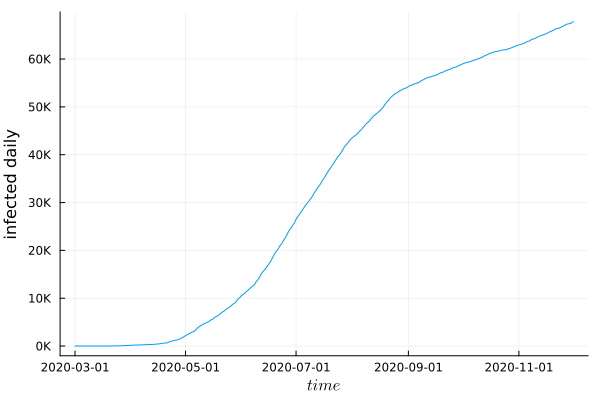

In [6]:
@df ng plot(:dates,
    :confirmed,
    xlab=L"time", ylab="infected daily",
    yformatter=y -> string(round(Int64, y ÷ 1_000)) * "K",
    label=false)

In [7]:
function sir_ode!(du, u, p, t)
    (S, E, I, R) = u
    (β, γ) = p
    N = S + I + R
    infection = β * I * S / N
    exposed = γ * E
    recovery = γ * I
    @inbounds begin
        du[1] = -infection # Susceptible
        du[2] = infection - exposed # Exposed
        du[2] = exposed - recovery # Infected
        du[3] = recovery # Recovered
    end
    nothing
end;

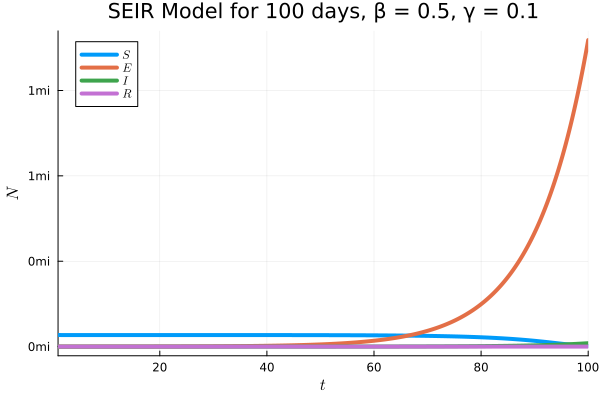

In [13]:
i₀ = first(ng[:, :confirmed])
N = last(ng[:, :confirmed])
e₀ = 100

u = [N - e₀ - i₀, e₀, i₀, 0.0]
p = [0.5, 0.1]
prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
sol_ode = solve(prob)
plot(sol_ode, label=[L"S" L"E" L"I" L"R"],
    lw=4,
    xlabel=L"t",
    ylabel=L"N",
    yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
    title="SEIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

In [21]:
function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

NegativeBinomial2 (generic function with 1 method)

In [22]:
seed!(123)

@model function bayes_sir(infected, e₀, i₀, r₀, N)
    #calculate number of timepoints
    l = length(infected)

    #priors
    β ~ TruncatedNormal(2, 1, 1e-4, 10)     # using 10 because numerical issues arose
    γ ~ TruncatedNormal(0.4, 0.5, 1e-4, 10) # using 10 because numerical issues arose
    ϕ⁻ ~ truncated(Exponential(5); lower=0, upper=1e5)
    ϕ = 1.0 / ϕ⁻

    #ODE Stuff
    I = i₀
    E = e₀
    u0 = [N - I, E - I, I, r₀] # S,I,R
    p = [β, γ]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_ode!,
        u0,
        tspan,
        p)
    sol = solve(prob,
        Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
        saveat=1.0)
    solᵢ = Array(sol)[2, :] # New Infected
    solᵢ = max.(1e-4, solᵢ) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(solᵢ, ϕ)))
end;

In [23]:
infected = ng[:, :confirmed]
r₀ = 0
model_sir = bayes_sir(infected, e₀, i₀, r₀, N)
chain_sir = sample(model_sir, NUTS(), 1_000)
summarystats(chain_sir[[:β, :γ]])

Sampling   0%|█                                         |  ETA: N/A


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\ajaoo\.julia\packages\SciMLBase\VKnrY\src\integrator_interface.jl:525
Sampling 100%|██████████████████████████████████████████| Time: 0:00:00


DimensionMismatch: DimensionMismatch: inconsistent array dimensions

In [24]:
plot(chain_sir)

UndefVarError: UndefVarError: chain_sir not defined

In [22]:
using LightGraphs

# Define the nodes as countries
nodes = ["USA", "China", "Italy", "Spain", "France", "Germany"]

# Define the edges as the demand between each country
edges = [(1, 2, 10), (1, 3, 5), (1, 4, 8), (1, 5, 6), (2, 3, 3), (2, 4, 7), (3, 4, 9), (3, 5, 4), (4, 5, 2)]

# Create the graph
g = SimpleGraph(nodes, edges)

MethodError: MethodError: no method matching SimpleGraph(::Vector{String}, ::Vector{Tuple{Int64, Int64, Int64}})
Closest candidates are:
  SimpleGraph(::Any, !Matched::Array{Vector{T}, 1}) where T at C:\Users\ajaoo\.julia\packages\LightGraphs\IgJif\src\SimpleGraphs\simplegraph.jl:18

In [ ]:
using LightGraphs

# Define the nodes of the network as countries
g = SimpleWeightedGraph()
countries = ["Canada", "Mexico", "United States"]
for country in countries
    add_vertex(g, country)
end

In [ ]:
function SEIR(du, u, p, t)
    S, E, I, R = u
    N = p[1]
    beta = p[2]
    sigma = p[3]
    gamma = p[4]
    du[1] = -beta * S * I / N
    du[2] = beta * S * I / N - sigma * E
    du[3] = sigma * E - gamma * I
    du[4] = gamma * I
end


In [20]:
using DifferentialEquations
using Plots

#Initialize parameters
beta = 0.2
gamma = 0.1
delta = 0.01
sigma = 0.05

#Initialize population sizes
s0 = 0.99
e0 = 0.01
i0 = 0
r0 = 0

#Define SEIR model
function SEIR(du, u, p, t)
S, E, I, R = u
du[1] = -beta*S*I
du[2] = beta*S*I - sigma*E
du[3] = sigma*E - gamma*I
du[4] = gamma*I
end

#Define initial conditions
u0 = [s0, e0, i0, r0]

#Define time range for simulation
tspan = (0.0, 100.0)

#Solve SEIR model
prob = ODEProblem(SEIR, u0, tspan)
sol = solve(prob, Tsit5())

#Extract data from solution
s = sol[1,:]
e = sol[2,:]
i = sol[3,:]
r = sol[4,:]

#Plot results
plot(sol.t, s, label="Susceptible")
plot!(sol.t, e, label="Exposed")
plot!(sol.t, i, label="Infected")
plot!(sol.t, r, label="Recovered")

#Calculate demand for vaccine
vaccine_demand = i .* s

# #Optimize vaccine allocation
# vaccine_allocation = optimize_vaccine_allocation(vaccine_demand)

# println("Optimized vaccine allocation: ", vaccine_allocation)

17-element Vector{Float64}:
 0.0
 6.462167962021548e-5
 0.0004518828367352362
 0.0010389510326913188
 0.0016211830349048756
 0.0022019133018129386
 0.0027461400802191115
 0.003280161740522861
 0.0038441576708442443
 0.004516631204680403
 0.005406403862275046
 0.006691870062238543
 0.008709302497676048
 0.012954434037861057
 0.01688554278758427
 0.022005379721331
 0.02291437342976022

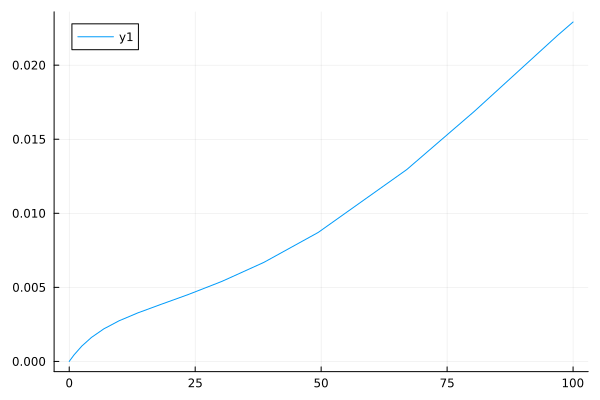

In [21]:
plot(sol.t, vaccine_demand)